In [1]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [2]:
import os
import tarfile
from six.moves import urllib
import numpy as np

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [3]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH,filename="file.tgz"):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, filename)
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
#call data download function
fetch_housing_data(HOUSING_URL,HOUSING_PATH,"housing.tgz")

In [6]:
#call panda read to load data to memory
houseData=load_housing_data(HOUSING_PATH)

In [7]:
houseData.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [9]:
houseData.describe()
#from the info, total_bedrooms is missing data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [9]:
#For categorical value
houseData["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [10]:
#describe the data
houseData.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


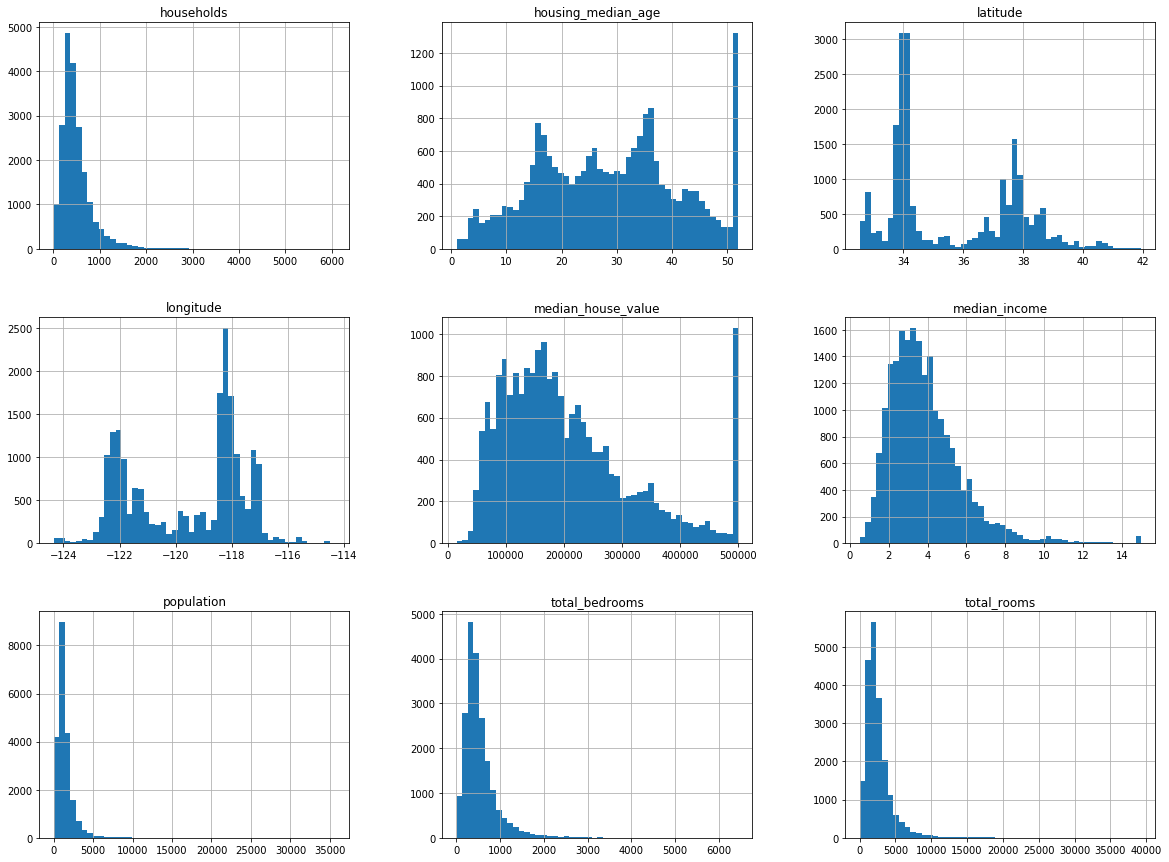

In [11]:
#only in a Jupyter notebook
#%matplotlib inline

import matplotlib.pyplot as plt
houseData.hist(bins=50, figsize=(20,15))
plt.show()

In [12]:
#splitting data
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [13]:
np.random.permutation(5)

array([2, 3, 0, 4, 1])

In [14]:
train_set, test_set = split_train_test(houseData, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


In [15]:
#To avoid testing data different for each run
# we hash the row index and take the last byte of the hash 
# and check if the hash is X% of the 256

In [16]:
import hashlib
from IPython.core.debugger import set_trace
def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    #set_trace()
    return data.loc[~in_test_set], data.loc[in_test_set]

In [17]:
housing_with_id = houseData.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [18]:
#default imeplementation of Sklearn, random_state always use the same seed
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(houseData, test_size=0.2, random_state=42)

In [19]:
#categorize the income
#1.5 as the width
houseData["income_cat"] = np.ceil(houseData["median_income"] / 1.5)

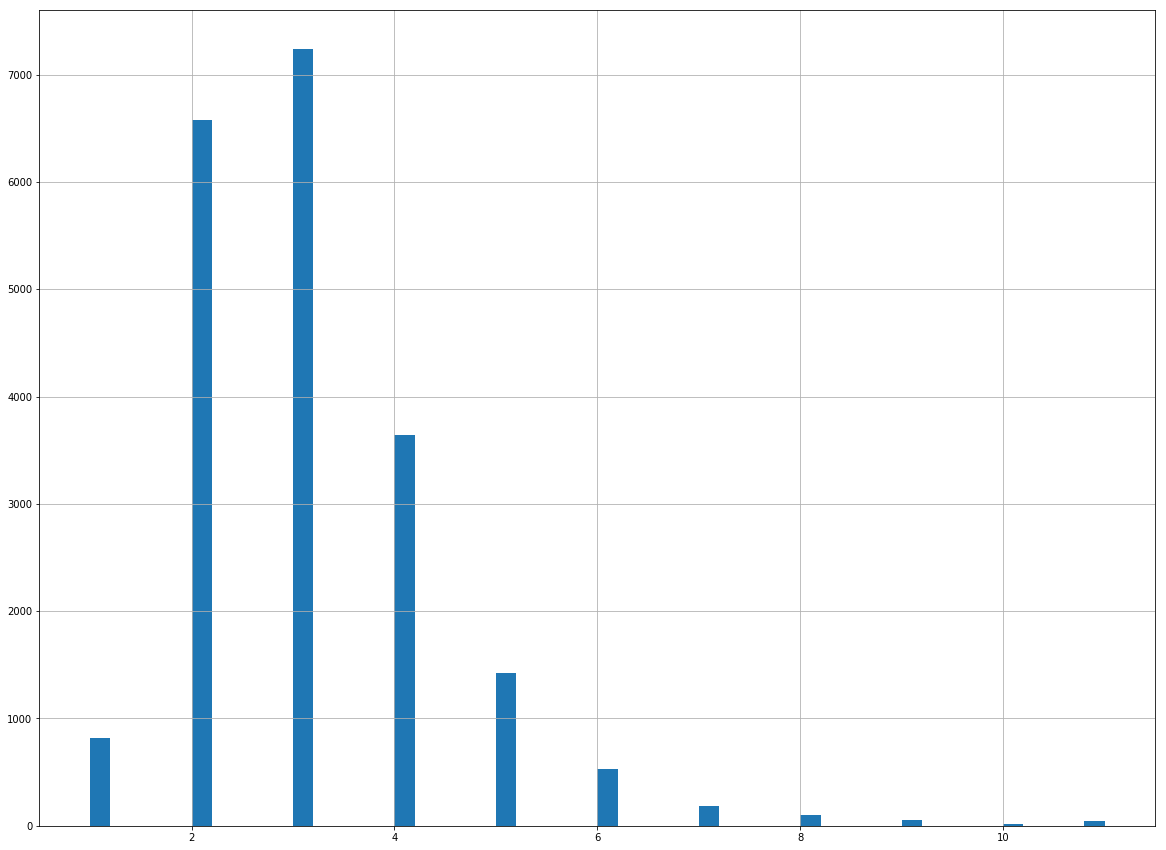

In [20]:
houseData["income_cat"].hist(bins=50, figsize=(20,15))
plt.show()

In [21]:
# reduce the long tail and limit to 5 category
houseData["income_cat"].where(houseData["income_cat"] < 5, 5.0, inplace=True)

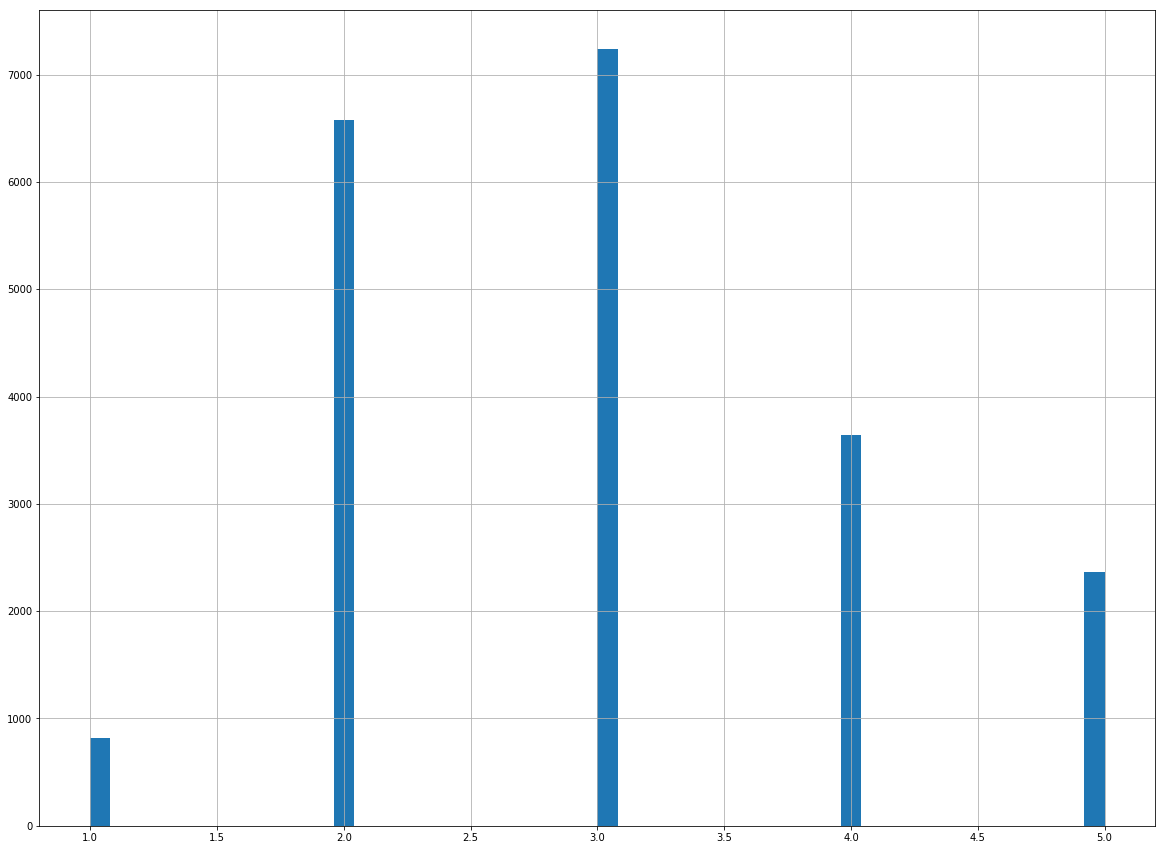

In [22]:
houseData["income_cat"].hist(bins=50, figsize=(20,15))
plt.show()

In [23]:
#Stratfy sampleing of income
#to avoid skewed test data
#the proportion of income are similar in both testing set and training set
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(houseData, houseData["income_cat"]):
    strat_train_set = houseData.loc[train_index]
    strat_test_set = houseData.loc[test_index]

In [24]:
houseData["income_cat"].value_counts() / len(houseData)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [25]:
strat_train_set["income_cat"].value_counts() / len(strat_train_set)

3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64

In [26]:
strat_test_set["income_cat"].value_counts()/len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [27]:
#remove the income_cat in the end
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# Visualizing Geographical Data

In [28]:
housing = strat_train_set.copy()

In [29]:
housing.plot(kind="scatter", x="longitude", y="latitude")

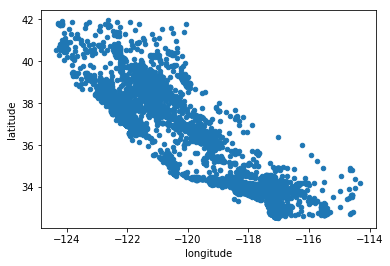

In [30]:
plt.show()

In [31]:
housing.plot(kind="scatter", x="longitude", y="latitude",alpha=0.1)

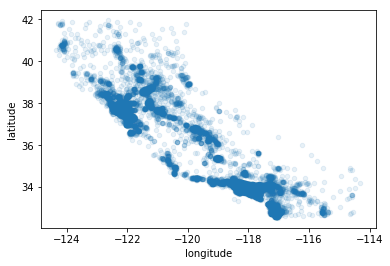

In [32]:
plt.show()

In [33]:
#s -> circle
#c -> color
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

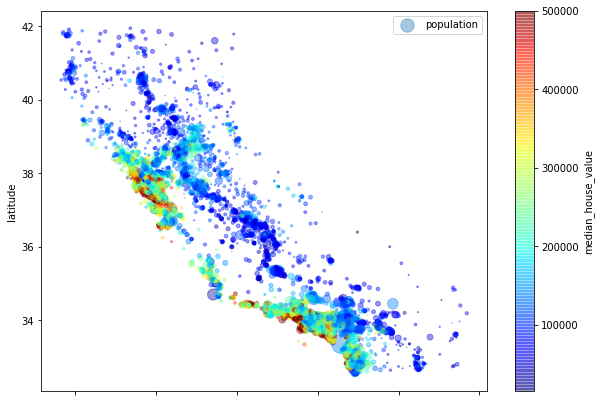

In [34]:
plt.show()

# Looking for correlation

In [35]:
corr_matrix = housing.corr()

In [36]:
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000


In [37]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

In [38]:
from pandas.tools.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa8f020c630>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fa8efdfaba8>]], dtype=object)

In [39]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)

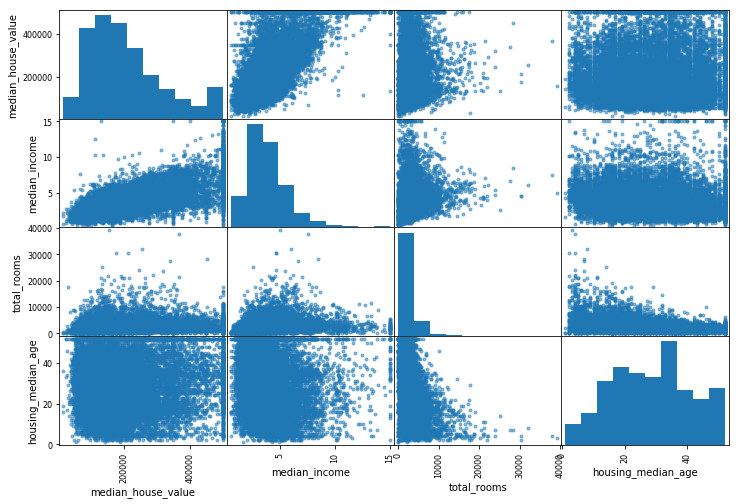

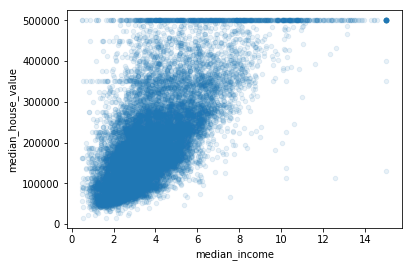

In [40]:
plt.show()

In [41]:
housing["bedroomPerRm"]= housing["total_bedrooms"]/housing["total_rooms"]

In [42]:
housing["populationPerHousehold"]=housing["population"]/housing["households"]

In [43]:
corr_matrix = housing.corr()

In [44]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value        1.000000
median_income             0.687160
total_rooms               0.135097
housing_median_age        0.114110
households                0.064506
total_bedrooms            0.047689
populationPerHousehold   -0.021985
population               -0.026920
longitude                -0.047432
latitude                 -0.142724
bedroomPerRm             -0.259984
Name: median_house_value, dtype: float64

In [45]:
strat_train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


In [46]:
housing2 = strat_train_set.drop("median_house_value", axis=1)

In [47]:
housing_labels = strat_train_set["median_house_value"].copy()

In [48]:
housing2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 9 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


# Data Cleaning

In [49]:
#housing2.dropna(subset=["total_bedrooms"])    # option 1
#housing2.drop("total_bedrooms", axis=1)       # option 2
#median = housing2["total_bedrooms"].median()  # option 3
#housing2["total_bedrooms"].fillna(median, inplace=True)

In [50]:
from sklearn.preprocessing import Imputer
#apply median if the value is NA!!!
imputer = Imputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)
imputer.statistics_

array([ -1.18510000e+02,   3.42600000e+01,   2.90000000e+01,
         2.11950000e+03,   4.33000000e+02,   1.16400000e+03,
         4.08000000e+02,   3.54090000e+00,   1.79500000e+05,
         2.03031374e-01,   2.81765270e+00])

In [51]:
X = imputer.transform(housing_num)

In [52]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

# Text and Categorical Attributes

In [53]:
housing_cat = housing["ocean_proximity"]

In [54]:
housing_cat.head()

17606     <1H OCEAN
18632     <1H OCEAN
14650    NEAR OCEAN
3230         INLAND
3555      <1H OCEAN
Name: ocean_proximity, dtype: object

In [55]:
housing_cat_encoded, housing_categories = housing_cat.factorize()

In [56]:
housing_cat_encoded[:10]

array([0, 0, 1, 2, 0, 2, 0, 2, 0, 0])

In [57]:
housing_categories

Index(['<1H OCEAN', 'NEAR OCEAN', 'INLAND', 'NEAR BAY', 'ISLAND'], dtype='object')

In [58]:
from sklearn.preprocessing import OneHotEncoder

In [59]:
encoder = OneHotEncoder()

In [60]:
#fit_transform expect a 2D array... we reshape it to 2D array
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))

In [61]:
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [62]:
np.shape(housing_cat_1hot.toarray())

(16512, 5)

In [63]:
cat_encoder = CategoricalEncoder()

In [64]:
housing_cat_reshaped = housing_cat.values.reshape(-1, 1)

In [65]:
housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)

In [66]:
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [67]:
cat_encoder = CategoricalEncoder(encoding="onehot-dense")

In [68]:
housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)

In [69]:
housing_cat_1hot

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

In [70]:
#Custom transformer

from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

# Transformation Pipelines

In [71]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])
#clean the data set before running next experiment
housing = strat_train_set.drop("median_house_value", axis=1).copy()
housing_num = housing.drop("ocean_proximity", axis=1)
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [72]:
housing_num.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


In [73]:
p=housing_num.columns.copy()

In [74]:
p=np.append(p,["population_per_household","population_per_household","bedrooms_per_room"])

In [75]:
p_housing_num_tr = pd.DataFrame(housing_num_tr,columns=p)

In [76]:
p_housing_num_tr.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,population_per_household,population_per_household,bedrooms_per_room
count,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04
mean,-4.353107e-15,2.284564e-15,-4.701235e-17,7.587062e-17,1.360615e-16,-3.700743e-17,2.078979e-17,-2.102108e-16,8.014691e-17,-1.621765e-17,-4.878742e-17
std,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00
min,-2.384937e+00,-1.449760e+00,-2.199168e+00,-1.223689e+00,-1.294944e+00,-1.269921e+00,-1.317668e+00,-1.772116e+00,-1.650273e+00,-2.075303e-01,-2.704542e+00
25%,-1.111083e+00,-7.949406e-01,-8.472092e-01,-5.516890e-01,-5.793145e-01,-5.698825e-01,-5.803963e-01,-6.870806e-01,-3.822514e-01,-5.741738e-02,-5.914834e-01
50%,5.324379e-01,-6.452675e-01,2.758786e-02,-2.353301e-01,-2.458409e-01,-2.292746e-01,-2.370459e-01,-1.756999e-01,-7.966522e-02,-2.406537e-02,-1.628895e-01
75%,7.822131e-01,9.730728e-01,6.638039e-01,2.423650e-01,2.604547e-01,2.684162e-01,2.793106e-01,4.561338e-01,2.358755e-01,1.596812e-02,4.044268e-01
max,2.630550e+00,2.951564e+00,1.856709e+00,1.716114e+01,1.381603e+01,3.071047e+01,1.293803e+01,5.839969e+00,5.225419e+01,1.070603e+02,3.975916e+01


In [77]:
#Data Selector
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [78]:
list(housing_num)

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

In [79]:
num_attribs=['longitude','latitude','housing_median_age','total_rooms','total_bedrooms','population','households','median_income']
cat_attribs = ["ocean_proximity"]

In [80]:
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
    ])

In [81]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [82]:
housing_prepared = full_pipeline.fit_transform(housing)

In [83]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

# Training with a model (Libear regression)

In [84]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [85]:
#try some data from training set
#tHousing = strat_test_set.drop()
some_data = housing.iloc[:5]
some_label=housing_labels.iloc[:5]

In [86]:
some_data_prepared = full_pipeline.transform(some_data)

In [87]:
print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [ 210644.60459286  317768.80697211  210956.43331178   59218.98886849
  189747.55849879]


In [88]:
print("Labels:", list(some_label))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [89]:
from sklearn.metrics import mean_squared_error

In [90]:
housing_predictions = lin_reg.predict(housing_prepared)

In [91]:
lin_mse = mean_squared_error(housing_labels, housing_predictions)

In [92]:
lin_rmse = np.sqrt(lin_mse)

In [93]:
lin_rmse

68628.198198489234

# Training with a model (Decision Tree)

In [94]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [95]:
housing_predictions = tree_reg.predict(housing_prepared)

In [96]:
dt_mse = mean_squared_error(housing_labels, housing_predictions)

In [97]:
dt_rmse = np.sqrt(dt_mse)

In [98]:
#Overfit the data?
dt_rmse

0.0

# Cross validation on Decision Tree

In [99]:
#K-fold validation
#cut the training into 10 folds
#1 fold for validation, 9 folds for training
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)

#SckskiLearn expect a utilitu function (greater is better)
#but, our cost function is lower than better
#So, we need to multiply -1 in the output scores
tree_rmse_scores = np.sqrt(-scores)

In [100]:
def display_scores(scores):
    print("Scores:",scores)
    print ("Mean:",scores.mean())
    print ("Std",scores.std())

In [101]:
display_scores(tree_rmse_scores)

Scores: [ 71273.67861784  64708.86817231  72342.44786746  70699.53668262
  71030.35456888  74302.41027167  71259.03296143  71137.81333902
  77567.61089608  71115.94762661]
Mean: 71543.7701004
Std 3045.13886791


In [102]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-scores)

In [103]:
display_scores(lin_rmse_scores)

Scores: [ 66782.73843989  66960.118071    70347.95244419  74739.57052552
  68031.13388938  71193.84183426  64969.63056405  68281.61137997
  71552.91566558  67665.10082067]
Mean: 69052.4613635
Std 2731.6740018


when compare with decision tree cross validation result with linear model cross validation result
Decision tree overfit badly

# Switch to Random Forest regressor

In [104]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [105]:
scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
randomForest_rmse_scores = np.sqrt(-scores)

In [106]:
display_scores(randomForest_rmse_scores)

Scores: [ 51866.01087471  50540.41926306  53402.15358432  54754.07905884
  51572.72715228  56138.19319762  51167.21685164  50603.26924758
  54460.71762783  52565.39685681]
Mean: 52707.0183715
Std 1817.33210552


# Fine tune your model (GridSearch - brutal force)

In [107]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

In [108]:
forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error')

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [109]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [110]:
best_forest_reg=grid_search.best_estimator_
scores = cross_val_score(best_forest_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
randomForest_rmse_scores = np.sqrt(-scores)
display_scores(randomForest_rmse_scores)

Scores: [ 49249.37907947  47047.64159132  49059.65509274  50845.15520387
  49569.92306004  52721.62315813  47923.33109423  48193.69973453
  51980.46339985  49868.90104439]
Mean: 49645.9772459
Std 1695.05050353


In [111]:
#Display evaluation score
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64446.7007501 {'max_features': 2, 'n_estimators': 3}
55517.9169629 {'max_features': 2, 'n_estimators': 10}
52702.4121568 {'max_features': 2, 'n_estimators': 30}
60989.9173004 {'max_features': 4, 'n_estimators': 3}
52996.9362883 {'max_features': 4, 'n_estimators': 10}
50454.4602233 {'max_features': 4, 'n_estimators': 30}
59844.4421362 {'max_features': 6, 'n_estimators': 3}
52189.1099134 {'max_features': 6, 'n_estimators': 10}
50034.2422195 {'max_features': 6, 'n_estimators': 30}
58663.5412872 {'max_features': 8, 'n_estimators': 3}
52234.3470282 {'max_features': 8, 'n_estimators': 10}
50057.784391 {'max_features': 8, 'n_estimators': 30}
62462.8554291 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54558.1837768 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
61033.848379 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52871.6011659 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
58497.6855752 {'bootstrap': False, 'max_features': 4, 'n_estimat

# Feature attribute importance
# check the contribution of discretion power of each feature attribute

In [112]:
feature_importances = grid_search.best_estimator_.feature_importances_

In [113]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = cat_pipeline.named_steps["cat_encoder"]

In [114]:
cat_one_hot_attribs = list(cat_encoder.categories_[0])

In [115]:
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

In [116]:
sorted(zip(feature_importances, attributes), reverse=True)

[(0.34409766024445526, 'median_income'),
 (0.15158731089842836, 'INLAND'),
 (0.10750151062835453, 'pop_per_hhold'),
 (0.077987522729205311, 'bedrooms_per_room'),
 (0.076884493613326457, 'longitude'),
 (0.064938871800883993, 'latitude'),
 (0.042762141867779303, 'housing_median_age'),
 (0.042588023767198127, 'rooms_per_hhold'),
 (0.01839987587745762, 'population'),
 (0.018169058198024193, 'total_rooms'),
 (0.016380910731577679, 'households'),
 (0.015940718633080993, 'total_bedrooms'),
 (0.013786623526436838, '<1H OCEAN'),
 (0.0051809476260919508, 'NEAR OCEAN'),
 (0.0036583069363807248, 'NEAR BAY'),
 (0.00013602292131869318, 'ISLAND')]

In [117]:
final_model = grid_search.best_estimator_

In [118]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [120]:
final_rmse

47812.197265940944

In [168]:
#reload data
#call panda read to load data to memory
houseData=load_housing_data(HOUSING_PATH)


housing_cat = houseData["ocean_proximity"]
housing_cat.value_counts()

cat_encoder = CategoricalEncoder()
housing_cat_reshaped = housing_cat.values.reshape(-1, 1)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)
houseData.drop("ocean_proximity",axis=1,inplace=True)

from sklearn.preprocessing import Imputer
#apply median if the value is NA!!!
imputer = Imputer(strategy="median")

imputer.fit(houseData)
X = imputer.transform(houseData)
houseData = pd.DataFrame(X, columns=houseData.columns,
                          index = list(houseData.index.values))

In [169]:



#Stratfy sampleing of income
#to avoid skewed test data
#the proportion of income are similar in both testing set and training set
from sklearn.model_selection import StratifiedShuffleSplit
houseData["income_cat"] = np.ceil(houseData["median_income"] / 1.5)
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(houseData, houseData["income_cat"]):
    strat_train_set = houseData.loc[train_index]
    strat_test_set = houseData.loc[test_index]
#remove the income_cat in the end
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)
housing_labels=strat_train_set["median_house_value"]
housing_prepared=strat_train_set.drop("median_house_value",axis=1)

In [170]:
housing_prepared.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 8 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16512 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
dtypes: float64(8)
memory usage: 1.1 MB


Question 1
Try a Support Vector Machine regressor (sklearn.svm.SVR), with various hyperparameters such as kernel="linear" (with various values for the C hyperparameter) or kernel="rbf" (with various values for the C and gamma hyperparameters). Don’t worry about what these hyperparameters mean for now. How does the best SVR predictor perform?

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=10.0, kernel=linear ...........................................
[CV] C=10.0, kernel=linear ...........................................
[CV] C=10.0, kernel=linear ...........................................
[CV] C=10.0, kernel=linear ...........................................


3
